In [1]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
LEARNING_RATE = 0.001
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42
BATCH_SIZE = 3072

In [4]:
# # use validation year: change path
# X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
# y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

# X = torch.from_numpy(X).type(torch.float)
# y = torch.from_numpy(y).type(torch.float)

# X_train, X_test, y_train, y_test = train_test_split(X,
#     y,
#     test_size=0.2,
#     random_state=RANDOM_SEED
# )

# use all 8 years: change path
X_train=np.load('/work/sds-lab/Shuochen/climsim/train_input.npy')
y_train=np.load('/work/sds-lab/Shuochen/climsim/train_target.npy')
X_test=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
y_test=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

In [5]:
# # split datasets to training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# create datasets
training_set = TensorDataset(X_train, y_train)
testing_set = TensorDataset(X_test, y_test)
# create dataloaders
train_dataloader = DataLoader(training_set, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)
test_dataloader = DataLoader(testing_set,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [6]:
class MLP(nn.Module):
    def __init__(self, IN_FEATURES, OUT_FEATURES):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(IN_FEATURES, 768),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(768, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 512),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(512, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 128),
                                 nn.LeakyReLU(0.15))
        # self.linear1 = nn.Linear(128, 120)
        # self.linear2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()

    def forward(self, x):
        temp = self.seq(x)
        a = temp[:,:120]
        b = self.relu(temp[:,120:])
        return torch.concat((a, b), dim=1)
        
model = MLP(IN_FEATURES, OUT_FEATURES).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(),lr=LEARNING_RATE)
# to do: scheduler




In [7]:
print(model)

MLP(
  (seq): Sequential(
    (0): Linear(in_features=124, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.15)
    (2): Linear(in_features=768, out_features=640, bias=True)
    (3): LeakyReLU(negative_slope=0.15)
    (4): Linear(in_features=640, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.15)
    (6): Linear(in_features=512, out_features=640, bias=True)
    (7): LeakyReLU(negative_slope=0.15)
    (8): Linear(in_features=640, out_features=640, bias=True)
    (9): LeakyReLU(negative_slope=0.15)
    (10): Linear(in_features=640, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.15)
  )
  (relu): ReLU()
)


In [8]:
torch.manual_seed(42)
epochs = 10
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X.to(device))
        loss = loss_fn(y_pred, y.to(device))
        train_loss += loss # accumulatively add up the loss per epoch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss.detach().cpu().numpy())
    
    with torch.inference_mode():
        test_loss = 0
        model.eval()
        for X, y in test_dataloader:
            test_pred = model(X.to(device))
            test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.00799 | Test loss: 0.00712
Epoch: 1 | Train loss: 0.00527 | Test loss: 0.00385
Epoch: 2 | Train loss: 0.00379 | Test loss: 0.00378
Epoch: 3 | Train loss: 0.00372 | Test loss: 0.00373
Epoch: 4 | Train loss: 0.00367 | Test loss: 0.00371
Epoch: 5 | Train loss: 0.00364 | Test loss: 0.00363
Epoch: 6 | Train loss: 0.00361 | Test loss: 0.00363
Epoch: 7 | Train loss: 0.00358 | Test loss: 0.00364
Epoch: 8 | Train loss: 0.00356 | Test loss: 0.00359
Epoch: 9 | Train loss: 0.00355 | Test loss: 0.00358


In [9]:
# combine batches
test_pred = []
with torch.inference_mode():
    test_loss = 0
    model.eval()
    for X, y in test_dataloader:
        test_pred_batch = model(X.to(device))
        test_pred.append(test_pred_batch)

test_pred = torch.cat(tuple(test_pred), dim=0)
# to cpu
test_pred = test_pred.detach().cpu().numpy()

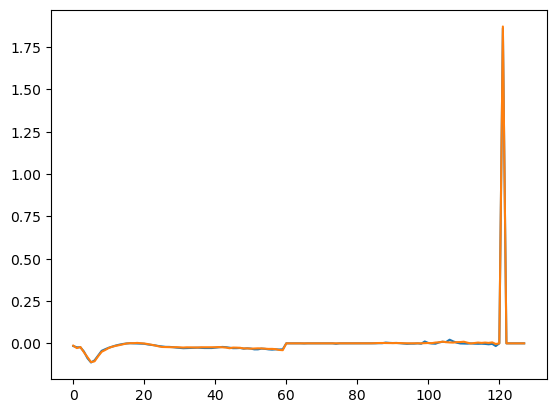

In [10]:
# plot the first sample. Delete this if not necessary.
plt.plot(test_pred[0,:])
plt.plot(y_test[0,:])

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1736960


# Post-processing (metric files)

In [12]:
# model name
# (model name is used for the output)
model_name = 'MLP'
# input of validation dataset (npy)
fn_x_true = '/work/sds-lab/Shuochen/climsim/val_input.npy'
# true output of validation dataset (npy)
fn_y_true = '/work/sds-lab/Shuochen/climsim/val_target.npy'
# Model predicted output of varlidation dataset (npy)
fn_y_pred = test_pred
# model grid information (nc)
fn_grid = '/work/sds-lab/Shuochen/climsim/normalizations_git/ClimSim_low-res_grid-info.nc'

# normalization and scale factors (nc), fn_mli files are not necessary
fn_mli_mean  = '/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_mean.nc'
fn_mli_min   = '/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_min.nc'
fn_mli_max   = '/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_max.nc'
fn_mlo_scale = '/work/sds-lab/Shuochen/climsim/normalizations_git/outputs/output_scale.nc'


In [13]:
# physical constatns from (E3SM_ROOT/share/util/shr_const_mod.F90)
grav    = 9.80616    # acceleration of gravity ~ m/s^2
cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
lv      = 2.501e6    # latent heat of evaporation ~ J/kg
lf      = 3.337e5    # latent heat of fusion      ~ J/kg
ls      = lv + lf    # latent heat of sublimation ~ J/kg
rho_air = 101325./ (6.02214e26*1.38065e-23/28.966) / 273.15 # density of dry air at STP  ~ kg/m^3
                                                            # ~ 1.2923182846924677
                                                            # SHR_CONST_PSTD/(SHR_CONST_RDAIR*SHR_CONST_TKFRZ)
                                                            # SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
                                                            # SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

vars_mlo_energy_conv = {'ptend_t':cp,
                        'ptend_q0001':lv,
                        'cam_out_NETSW':1.,
                        'cam_out_FLWDS':1.,
                        'cam_out_PRECSC':lv*rho_h20,
                        'cam_out_PRECC':lv*rho_h20,
                        'cam_out_SOLS':1.,
                        'cam_out_SOLL':1.,
                        'cam_out_SOLSD':1.,
                        'cam_out_SOLLD':1.
                       }
vars_longname=\
{'ptend_t':'Heating tendency, ∂T/∂t',
 'ptend_q0001':'Moistening tendency, ∂q/∂t',
 'cam_out_NETSW':'Net surface shortwave flux, NETSW',
 'cam_out_FLWDS':'Downward surface longwave flux, FLWDS',
 'cam_out_PRECSC':'Snow rate, PRECSC',
 'cam_out_PRECC':'Rain rate, PRECC',
 'cam_out_SOLS':'Visible direct solar flux, SOLS',
 'cam_out_SOLL':'Near-IR direct solar flux, SOLL',
 'cam_out_SOLSD':'Visible diffused solar flux, SOLSD',
 'cam_out_SOLLD':'Near-IR diffused solar flux, SOLLD'}

In [14]:
# set dimemsion names for xarray datasets
dim_name_level  = 'lev'
dim_name_sample = 'sample'

# load input dataset
x_true = np.load(fn_x_true)
y_true = np.load(fn_y_true)
y_pred = fn_y_pred
N_samples = y_pred.shape[0]

# load norm/scale factors
mlo_scale = xr.open_dataset(fn_mlo_scale)
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

In [15]:
# load grid information
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
N_ncol = len(ds_grid['ncol']) # length of ncol dimension (nlat * nlon)

# make area-weights
ds_grid['area_wgt'] = ds_grid['area'] / ds_grid['area'].mean('ncol')

# map ds_grid's ncol dimension -> the N_samples dimension of npy-loayd arrays (e.g., y_pred)
to_xarray = {'area_wgt': (dim_name_sample,np.tile(ds_grid['area_wgt'], int(N_samples/len(ds_grid['ncol'])))),
            }
to_xarray = xr.Dataset(to_xarray)

# add nsample-mapped grid variables back to ds_grid
ds_grid = xr.merge([ds_grid  [['P0', 'hyai', 'hyam','hybi','hybm','lat','lon','area']],
                    to_xarray[['area_wgt']]])

In [16]:
# list of ML output variables
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD'] # mlo mean ML output.

# length of each variable
# (make sure that the order of variables are correct)
vars_mlo_len = {'ptend_t':60,
                'ptend_q0001':60,
                'cam_out_NETSW':1,
                'cam_out_FLWDS':1,
                'cam_out_PRECSC':1,
                'cam_out_PRECC':1,
                'cam_out_SOLS':1,
                'cam_out_SOLL':1,
                'cam_out_SOLSD':1,
                'cam_out_SOLLD':1
               }

# map the length of dimension to the name of dimension
len_to_dim = {60:dim_name_level,
              N_samples: dim_name_sample}

In [17]:
# Here, we first construct a dictionary of {var name: (dimension name, array-like)},
# then, map the dictionary to an Xarray Dataset.
# (ref: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

DS = {}

for kds in ['true', 'pred']:
    if kds=='true':
        work = y_true
    elif kds=='pred':
        work = y_pred

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # unscaled output
        kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS[kds] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # denormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS[kds]['state_ps'] = state_ps

    # [4] add grid information
    DS[kds] = xr.merge([DS[kds], ds_grid])

    # [5] add pressure thickness of each level, dp
    # FYI, in a hybrid sigma vertical coordinate system, pressure at level z is
    # P[x,z] = hyam[z]*P0 + hybm[z]*PS[x,z],
    # where, hyam and hybm are 
    tmp = DS[kds]['P0']*DS[kds]['hyai'] + DS[kds]['state_ps']*DS[kds]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS[kds]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS[kds] = DS[kds].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, y_true, y_pred, x_true, state_ps, tmp

In [18]:
# [1] Weight vertical levels by dp/g that is equivalent to a mass of air within a grid cell per unit area [kg/m2]
# [2] Weight horizontal area of each grid cell by a[x]/mean(a[x]).
# [3] Unit conversion to a common energy unit

DS_ENERGY = {}
for kds in ['true','pred']:
    # Make a copy to keep original dataset
    DS_ENERGY[kds] = DS[kds].copy(deep=True)

    # vertical weighting / area weighting / unit conversion
    for kvar in vars_mlo:

        # [1] weight vertical levels by dp/g
        #     ONLY for vertically-resolved variables, e.g., ptend_{t,q0001}
        # dp/g = - \rho * dz
        if vars_mlo_len[kvar] == 60:
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar] * DS_ENERGY[kds]['dp']/grav

        # [2] weight area
        #     for ALL variables
        DS_ENERGY[kds][kvar] = DS_ENERGY[kds]['area_wgt'] * DS_ENERGY[kds][kvar]

        # [3] convert units to W/m2
        #     for variables with different units, e.g., ptend_{t,q0001}, precsc, precc
        DS_ENERGY[kds][kvar] =  vars_mlo_energy_conv[kvar] * DS_ENERGY[kds][kvar]

In [19]:
all_metrics = ['MAE','RMSE','R2']

# A. Calculate metrics
# After this step,
# ptend_{t,q0001} have [ncol, lev] dimension;
# and the rest variables have [ncol] dimension.

# if spatial analysis is desired (e.g., R2 distribution on global map or on latitude-level plane),
# the metrics at this step should be used.


# Select only ML output varibles
DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

# Caclulate 3 metrics
Metrics = {}
Metrics['MAE']  = (np.abs(DS_ENERGY['true']   - DS_ENERGY['pred'])).mean('time')
Metrics['RMSE'] = np.sqrt(((DS_ENERGY['true'] - DS_ENERGY['pred'])**2.).mean('time'))
Metrics['R2'] = 1 - ((DS_ENERGY['true'] - DS_ENERGY['pred']                    )**2.).sum('time')/\
                    ((DS_ENERGY['true'] - DS_ENERGY['true'].mean('time'))**2.).sum('time')

# Save grid-wise metric files in netcdf format
if True:
    for kmetric in ['MAE', 'RMSE', 'R2']:
        fn_save = f'./metrics_netcdf/{model_name}_{kmetric}.nc'
        Metrics[kmetric].to_netcdf(fn_save)

In [20]:
# B. Make horizontal mean.
# After this step,
# ptend_{t,q0001} have [lev] dimension;
# and the rest variables have zero dimensions, i.e., scalars.

for kmetric in all_metrics:
    Metrics[kmetric] = Metrics[kmetric].mean('ncol') # simple mean

In [21]:
# C-1. Save the result after B.
# to save in a table format as a csv file, the level dimensions are flattened.

Metrics_stacked = {}
for kmetric in all_metrics:
    Metrics_stacked[kmetric] = Metrics[kmetric].to_stacked_array('ml_out_idx', sample_dims='', name=kmetric)


# save the output
work = pd.DataFrame({'MAE':  Metrics_stacked['MAE'].values,
                     'RMSE': Metrics_stacked['RMSE'].values,
                     'R2':   Metrics_stacked['R2'].values}
                    )
work.index.name = 'output_idx'

# save to the metrics folder
fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
work.to_csv(fn_save_metrics)
work

,MAE,RMSE,R2
output_idx,,,
0,0.002771,0.005657,0.878984
1,0.006397,0.011964,0.906354
2,0.009640,0.015903,0.955291
3,0.016991,0.024203,0.977724
4,0.028676,0.037604,0.989999
...,...,...,...
123,36.337995,76.482245,-227.360068
124,8.715317,18.774777,0.953144
125,11.077572,23.318361,0.939096


<Axes: xlabel='output_idx'>

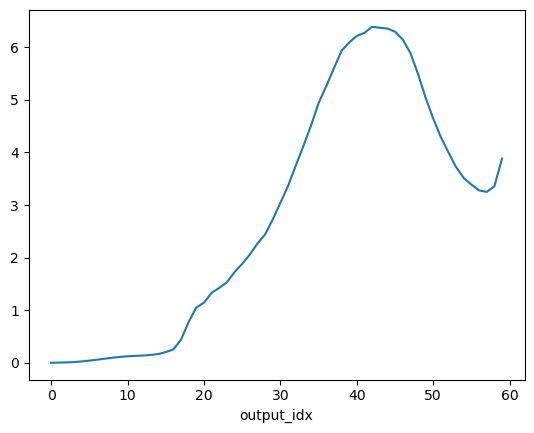

In [22]:
# try to reproduce their plot 2
work['MAE'][:60].plot()

In [23]:
# C-2. Save the result after vertical averaging.
# After this step,
# ptend_{t,q0001} also have zero dimensions, i.e., scalars;

# Then, the results are saved to a csv file.
# This csv file will be used for generating plots.

Metrics_vert_avg = {}
for kmetric in all_metrics:
    Metrics_vert_avg[kmetric] = Metrics[kmetric].mean('lev')
    Metrics_vert_avg[kmetric] = Metrics_vert_avg[kmetric].mean('ilev') # remove dummy dim

# save the output
work = pd.DataFrame({'MAE':  Metrics_vert_avg['MAE'].to_pandas(),
                     'RMSE': Metrics_vert_avg['RMSE'].to_pandas(),
                     'R2':   Metrics_vert_avg['R2'].to_pandas()}
                    )
work.index.name = 'Variable'

# save to the metrics folder
fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'
work.to_csv(fn_save_metrics_avg)
work

,MAE,RMSE,R2
Variable,,,
ptend_t,2.781737,4.569944,0.564616
ptend_q0001,4.627142,7.493035,-inf
cam_out_NETSW,15.236686,29.730560,0.976438
cam_out_FLWDS,5.739177,7.530553,0.908773
cam_out_PRECSC,3.034113,5.440673,-inf
cam_out_PRECC,36.337995,76.482245,-227.360068
cam_out_SOLS,8.715317,18.774777,0.953144
cam_out_SOLL,11.077572,23.318361,0.939096
cam_out_SOLSD,5.001318,10.153138,0.948937
